<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/04/cropped-Logo_Quantreo_transparent.png" align="left" hspace="10px" vspace="0px"></p>

# Strategy  with RSI

In order to create the strategy of this section, we are going to import a new library which is the ta (technical analysis) library. The strategy will be created using the RSI indicator (detailed description in the next box).

### Content

* Explanation and computation of the RSI
* Do a strategy with the RSI
* Automate the strategy 

In [ ]:
!pip install ta
!pip install yfinance
!pip install hurst

  Created wheel for ta: filename=ta-0.7.0-cp37-none-any.whl size=28716 sha256=15fd0884adf4bf0575a027713be5e37f159cfa88f4bbf693dd105a757be06e1c
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta
     |████████████████████████████████| 6.3MB 8.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.60-py2.py3-none-any.whl size=23819 sha256=503fa3ed01db1f662acd762c67d1bd6c28631104d4ba9f61c677cc42ea934383
  Stored in directory: /root/.cache/pip/wheels/f0/be/a4/846f02c5985562250917b0ab7b33fff737c8e6e8cd5209aa3b
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# import library

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from tqdm import tqdm
from scipy.optimize import minimize
from hurst import compute_Hc
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# The code here will allow you to switch your graphics to dark mode for those who choose to code in dark mode

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

# Section 1: Explanation and computation of the RSI

### Explanation
The RSI (Relative Strength Index) will allow you to understand the strength of a trend and identify the end of a trend. The RSI value will vary from 0 to 100.

* If the RSI is around the 70 level, it is assumed that the instrument is overbought. This is a situation where prices have risen sharply, and the movement is likely to weaken.
* If the RSI is around the 30 level, this is a technical signal that the instrument may be oversold. In this case, it is a situation where prices have fallen sharply, and the movement may now lose strength.
* If the indicator oscillates horizontally around the 50 level, it means that the market is lacking a trend. The 50 level is the middle line that separates the bullish and bearish territories of the indicator...

It should be taken into account that the RSI is an indicator of the oscillator family, so it will work a little less well in markets with less volatility, such as the stock market.




In [ ]:
# Import the data
f = yf.download("GOOG")

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Compute the rsi
f["rsi"] = ta.momentum.RSIIndicator(f["Adj Close"], window=14).rsi()
f

,Open,High,Low,Close,Adj Close,Volume,rsi
Date,,,,,,,
2004-08-19,49.813290,51.835709,47.800831,49.982655,49.982655,44871361,NaN
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942874,NaN
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342897,NaN
2004-08-24,55.412300,55.591629,51.591621,52.239197,52.239197,15319808,NaN
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232276,NaN
...,...,...,...,...,...,...,...
2021-06-29,2535.449951,2540.000000,2508.739990,2520.370117,2520.370117,1047500,60.314211
2021-06-30,2513.071045,2516.000000,2495.149902,2506.320068,2506.320068,1200300,56.481830
2021-07-01,2496.995117,2529.250000,2496.995117,2527.370117,2527.370117,856000,60.528456


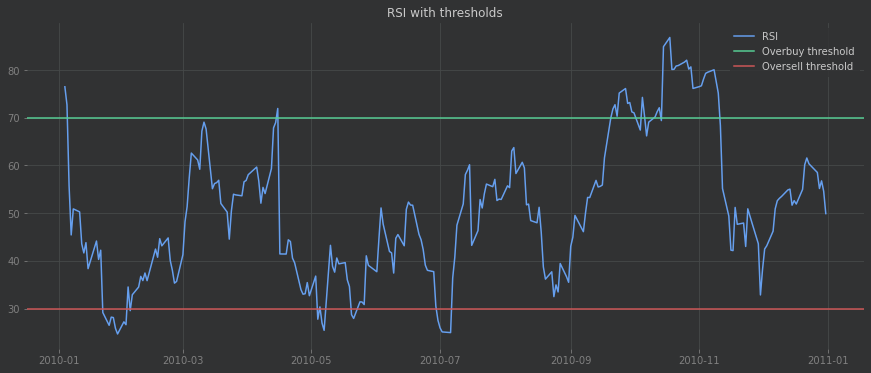

In [ ]:
# Plot the RSI with the overbuy and overell threshold

# Adapt the size of the graph
plt.figure(figsize=(15,6))

# View the RSI
plt.plot(f["rsi"].loc["2010"])

# View horizontal line for the Overbuy threshold (RSI=70)
plt.axhline(70, color="#57CE95")

# View horizontal line for the Oversell threshold (RSI=30)
plt.axhline(30, color="#CE5757")

# Put a title
plt.title("RSI with thresholds")

# Put a legend
plt.legend(["RSI", "Overbuy threshold", "Oversell threshold"])

# Show the graph
plt.show()

# Section 2: Do a strategy with the RSI

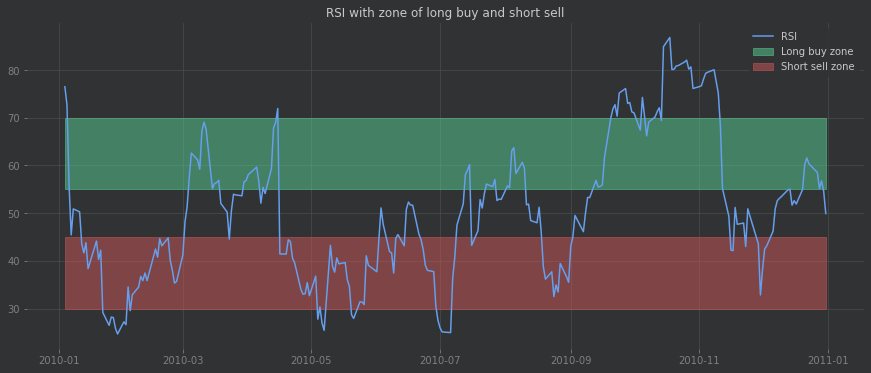

In [ ]:
# Plot the RSI with the Long buy zone and Short sell zone

# Adapt the size of the graph
plt.figure(figsize=(15,6))

# View the RSI
plt.plot(f["rsi"].loc["2010"])

# View horizontal line for the Overbuy threshold (RSI=70)
plt.fill_between(f["rsi"].loc["2010"].index,55,
                 70,55<70, color="#57CE95",
                  alpha=0.5)

# View horizontal line for the Oversell threshold (RSI=30)
plt.fill_between(f["rsi"].loc["2010"].index,45,
                 30,30<45, color="#CE5757",
                  alpha=0.5)
# Put a title
plt.title("RSI with zone of long buy and short sell")

# Put a legend
plt.legend(["RSI", "Long buy zone", "Short sell zone"])

# Show the graph
plt.show()

In [ ]:
# We define when the strategy must take a long buy or a short sell

# We need define the Open Long signal and Close Long signal

# We put threshold
overbuy = 70
neutral_buy = 55

# Put nan values for the signal long columns
f["signal_long"] = np.nan
f["yersteday_rsi"] = f["rsi"].shift(1)
# We need define the Open Long signal (RSI yersteday<55 and RSI today>55)
f.loc[(f["rsi"]>neutral_buy) & (f["yersteday_rsi"]<neutral_buy), "signal_long"] = 1

# We need define the Close Long signal (RSI yersteday>55 and RSI today<55) False signal
f.loc[(f["rsi"]<neutral_buy)&(f["yersteday_rsi"]>neutral_buy), "signal_long"] = 0

# We need define the Close Long signal (RSI yersteday>70 and RSI today<70) Over buy signal
f.loc[(f["rsi"]<overbuy)&(f["yersteday_rsi"]>overbuy), "signal_long"] = 0


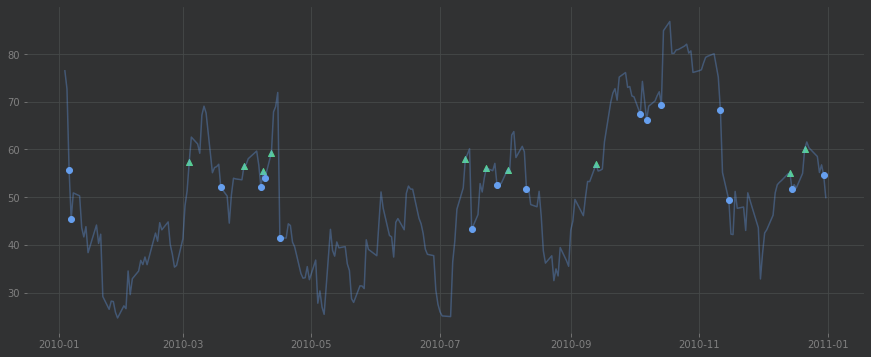

In [ ]:
# We plot all the signla to be sure that they be correct

# Select all signal in a index list to plot only this points
idx_open = f.loc[f["signal_long"]==1].loc["2010"].index
idx_close = f.loc[f["signal_long"]==0].loc["2010"].index


# Adapt the size of the graph
plt.figure(figsize=(15,6))

# Plot the points of the open long signal in green
plt.scatter(f.loc[idx_open]["rsi"].index, f.loc[idx_open]["rsi"].loc["2010"], color= "#57CE95", marker="^")

# Plot the points of the close long signal in blue
plt.scatter(f.loc[idx_close]["rsi"].index, f.loc[idx_close]["rsi"].loc["2010"], color= "#669FEE", marker="o")

# Plot the rsi to be sure that the conditions are completed
plt.plot(f["rsi"].loc["2010"].index, f["rsi"].loc["2010"], alpha=0.35)

# Show the graph
plt.show() 

In [ ]:
# We define when the strategy must take a long buy or a short sell

# ******************************************************************************
# We need define the Open Short signal and Close Short signal

# We put threshold
oversell = 30
neutral_buy = 45

# Put nan values for the signal short columns
f["signal_short"] = np.nan
f["yersteday_rsi"] = f["rsi"].shift(1)
# We need define the Open short signal (RSI yersteday>45 and RSI today<45)
f.loc[(f["rsi"]<neutral_buy) & (f["yersteday_rsi"]>neutral_buy), "signal_short"] = -1

# We need define the Close short signal (RSI yersteday<45 and RSI today>45) False signal
f.loc[(f["rsi"]>neutral_buy)&(f["yersteday_rsi"]<neutral_buy), "signal_short"] = 0

# We need define the Close short signal (RSI yersteday<30 and RSI today>30) Over sell signal
f.loc[(f["rsi"]>oversell)&(f["yersteday_rsi"]<oversell), "signal_short"] = 0

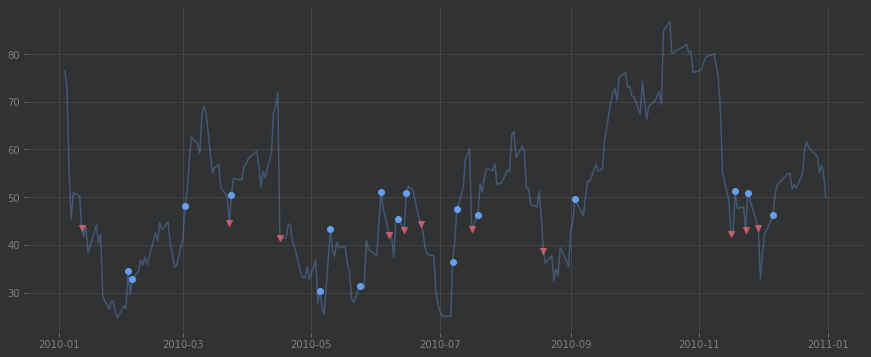

In [ ]:
# We plot all the signal to be sure that they be correct

idx_open = f.loc[f["signal_short"]==-1].loc["2010"].index
idx_close = f.loc[f["signal_short"]==0].loc["2010"].index

# Adapt the size of the graph
plt.figure(figsize=(15,6))

# Plot the points of the open short signal in red
plt.scatter(f.loc[idx_open]["rsi"].index, f.loc[idx_open]["rsi"].loc["2010"], color= "#CE5757", marker="v")

# Plot the points of the close short signal in blue
plt.scatter(f.loc[idx_close]["rsi"].index, f.loc[idx_close]["rsi"].loc["2010"], color= "#669FEE", marker="o")

# Plot the rsi to be sure that the conditions are completed
plt.plot(f["rsi"].loc["2010"].index, f["rsi"].loc["2010"], alpha=0.35)

# Show the graph
plt.show()

In [ ]:
f["Position"] = (f["signal_short"].fillna(method="ffill")+ f["signal_long"].fillna(method="ffill"))

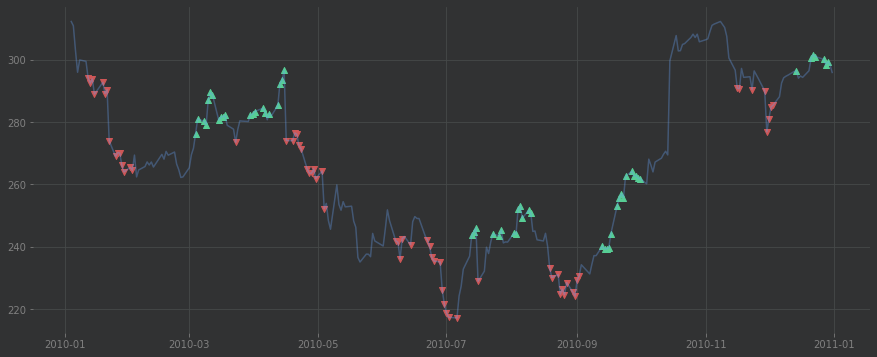

In [ ]:
# We plot all the signal to be sure that they be correct
year = "2010"
idx_long = f.loc[f["Position"]==1].loc[year].index
idx_short = f.loc[f["Position"]==-1].loc[year].index

# Adapt the size of the graph
plt.figure(figsize=(15,6))

# Plot the points of the short signal in red
plt.scatter(f.loc[idx_short]["Adj Close"].index, f.loc[idx_short]["Adj Close"].loc[year], color= "#CE5757", marker="v")

# Plot the points of the long signal in green
plt.scatter(f.loc[idx_long]["Adj Close"].index, f.loc[idx_long]["Adj Close"].loc[year], color= "#57CE95", marker="^")

# Plot the rsi to be sure that the conditions are completed
plt.plot(f["Adj Close"].loc[year].index, f["Adj Close"].loc[year], alpha=0.35)

# Show the graph
plt.show()

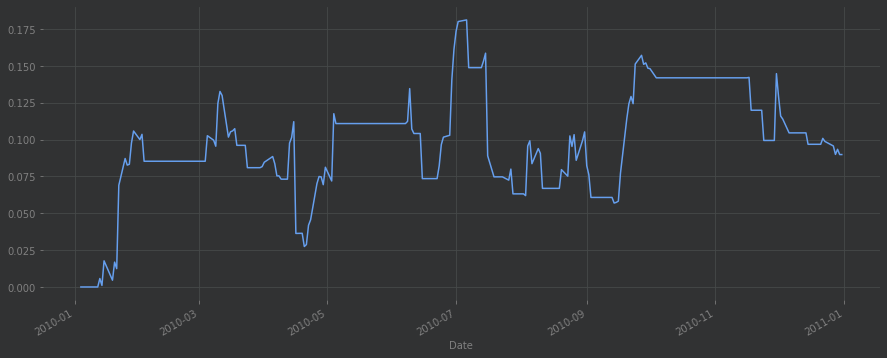

In [ ]:
# Compute the percentage of variation of the asset
f["pct"] = f["Adj Close"].pct_change(1)

# Compute the return of the strategy
f["return"] = f["pct"]*(f["Position"].shift(1))

f["return"].loc["2010"].cumsum().plot(figsize=(15,6))

# Create a function to do the RSI strategy later


In [ ]:
def RSI(val,neutral, window):
  """ 
        ------------------------------------------------------------------------------
        | Output: The function gives the returns of RSI strategy                     |
        ------------------------------------------------------------------------------
        | Inputs: -val (type dataframe pandas): Entry values of the stock            |
        |         -neutral (float): Value of neutrality, i.e. no action zone         |
        |         -window (float): rolling period for RSI                            |
        ------------------------------------------------------------------------------
  """

  # Print Error if there is no column Adj Close in the dataframe
  if "Adj Close" not in val.columns:
    ValueError("We need have a columns name Adj Close because all computation are about this column")
  
  val["rsi"] = ta.momentum.RSIIndicator(f["Adj Close"], window=window).rsi()


  
  """ Long buy Signal """
  # We put threshold
  overbuy = 70
  neutral_buy = 50 + neutral

  # Put nan values for the signal long columns
  val["signal_long"] = np.nan
  val["yersteday_rsi"] = f["rsi"].shift(1)
  # We need define the Open Long signal (RSI yersteday<55 and RSI today>55)
  val.loc[(val["rsi"]>neutral_buy) & (val["yersteday_rsi"]<neutral_buy), "signal_long"] = 1

  # We need define the Close Long signal (RSI yersteday>55 and RSI today<55) False signal
  val.loc[(val["rsi"]<neutral_buy)&(val["yersteday_rsi"]>neutral_buy), "signal_long"] = 0

  # We need define the Close Long signal (RSI yersteday>70 and RSI today<70) Over buy signal
  val.loc[(val["rsi"]<overbuy)&(val["yersteday_rsi"]>overbuy), "signal_long"] = 0



  """Short sell signal """
  # We put threshold
  oversell = 30
  neutral_buy = 50 - neutral

  # Put nan values for the signal short columns
  val["signal_short"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # We need define the Open Short signal (RSI yersteday>45 and RSI today<45)
  val.loc[(val["rsi"]<neutral_buy) & (val["yersteday_rsi"]>neutral_buy), "signal_short"] = -1

  # We need define the Close Short signal (RSI yersteday<45 and RSI today>45) False signal
  val.loc[(val["rsi"]>neutral_buy)&(val["yersteday_rsi"]<neutral_buy), "signal_short"] = 0

  # We need define the Close Short signal (RSI yersteday<30 and RSI today>30) Over sell signal
  val.loc[(val["rsi"]>oversell)&(val["yersteday_rsi"]<oversell), "signal_short"] = 0


  """ Compute the returns """
  # Compute the percentage of variation of the asset
  val["pct"] = val["Adj Close"].pct_change(1)

  # Compute the positions
  val["Position"] = (val["signal_short"].fillna(method="ffill")+ val["signal_long"].fillna(method="ffill"))

  # Compute the return of the strategy
  val["return"] = val["pct"]*(val["Position"].shift(1))

  return val["return"]

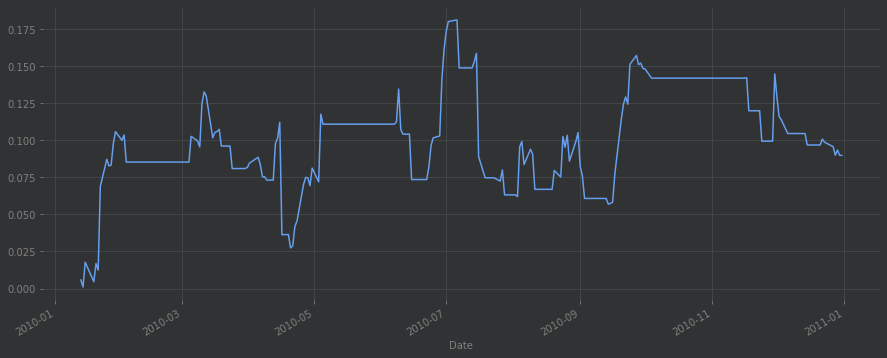

In [ ]:
RSI(f.loc["2010"],5, 14).cumsum().plot(figsize=(15,6))